# Summarizing Emails using Machine Learning: Data Wrangling
## Table of Contents
1. Imports & Initalization <br>
2. Data Input <br>
    A. Enron Email Dataset <br>
    B. BC3 Corpus <br>
3. Preprocessing <br>
    A. Data Cleaning. <br>
    B. Sentence Cleaning <br>
    C. Tokenizing <br>
4. Store Data <br>
    A. Locally as pickle <br>
    B. Into database <br>
5. Data Exploration <br>
    A. Enron Emails <br>
    B. BC3 Corpus <br>

The goal of this notebook is to clean both the Enron Email and BC3 Corpus data sets to perform email text summarization. The BC3 Corpus contains human summarizations that can be used to calculate ROUGE metrics to better understand how accurate the summarizations are. The Enron dataset is far more comprehensive, but lacks summaries to test against. 

You can find the text summarization notebook that uses the preprocessed data [here.](https://github.com/dailykirt/ML_Enron_email_summary/blob/master/notebooks/Text_rank_summarization.ipynb)

A visual summary of the preprocessing steps are in the figure below. 

<img src="./images/T.jpg">

## 1. Imports & Initalization

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import configparser
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import email
import mailparser
import xml.etree.ElementTree as ET
from talon.signature.bruteforce import extract_signature
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re

import dask.dataframe as dd
from distributed import Client
import multiprocessing as mp

/home/kirt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Set local location of emails. 
mail_dir = '../data/maildir/'
#mail_dir = '../data/testdir/'

## 2. Data Input 
### A. Enron Email Dataset
The raw enron email dataset contains a maildir directory that contains folders seperated by employee which contain the emails. The following processes the raw text of each email into a dask dataframe with the following columns: 

Employee: The username of the email owner. <br>
Body: Cleaned body of the email. <br>
Subject: The title of the email. <br>
From: The original sender of the email <br>
Message-ID: Used to remove duplicate emails, as each email has a unique ID. <br>
Chain: The parsed out email chain from a email that was forwarded. <br>
Signature: The extracted signature from the body.<br>
Date: Time the email was sent. <br>

All of the Enron emails were sent using the Multipurpose Internet Mail Extensions 1.0 (MIME) format. Keeping this in mind helps find the correct libraries and methods to clean the emails in a standardized fashion. 

In [3]:
def process_email(index):
    '''
    This function splits a raw email into constituent parts that can be used as features.
    '''
    email_path = index[0]
    employee = index[1]
    folder = index[2]
    
    mail = mailparser.parse_from_file(email_path)
    full_body = email.message_from_string(mail.body)
    
    #Only retrieve the body of the email. 
    if full_body.is_multipart():
        return
    else:
        mail_body = full_body.get_payload()    
    
    split_body = clean_body(mail_body)
    headers = mail.headers
    #Reformating date to be more pandas readable
    date_time = process_date(headers.get('Date'))

    email_dict = {
                "employee" : employee,
                "email_folder": folder,
                "message_id": headers.get('Message-ID'),
                "date" : date_time,
                "from" : headers.get('From'),
                "subject": headers.get('Subject'),
                "body" : split_body['body'],
                "chain" : split_body['chain'],
                "signature": split_body['signature'],
                "full_email_path" : email_path #for debug purposes. 
    }
    
    #Append row to dataframe. 
    return email_dict

In [4]:
def clean_body(mail_body):
    '''
    This extracts both the email signature, and the forwarding email chain if it exists. 
    '''
    delimiters = ["-----Original Message-----","To:","From"]
    
    #Trying to split string by biggest delimiter. 
    old_len = sys.maxsize
    
    for delimiter in delimiters:
        split_body = mail_body.split(delimiter,1)
        new_len = len(split_body[0])
        if new_len <= old_len:
            old_len = new_len
            final_split = split_body
            
    #Then pull chain message
    if (len(final_split) == 1):
        mail_chain = None
    else:
        mail_chain = final_split[1] 
    
    #The following uses Talon to try to get a clean body, and seperate out the rest of the email. 
    clean_body, sig = extract_signature(final_split[0])
    
    return {'body': clean_body, 'chain' : mail_chain, 'signature': sig}

In [5]:
def process_date(date_time):
    '''
    Converts the MIME date format to a more pandas friendly type. 
    '''
    try:
        date_time = email.utils.format_datetime(email.utils.parsedate_to_datetime(date_time))
    except:
        date_time = None
    return date_time

In [6]:
def generate_email_paths(mail_dir):
    '''
    Given a mail directory, this will generate the file paths to each email in each inbox. 
    '''
    mailboxes = listdir(mail_dir)
    for mailbox in mailboxes:
        inbox = listdir(mail_dir + mailbox)
        for folder in inbox:
            path = mail_dir + mailbox + "/" + folder
            emails = listdir(path)
            for single_email in emails:
                full_path = path + "/" + single_email
                if isfile(full_path): #Skip directories.
                    yield (full_path, mailbox, folder)
    

In [7]:
#Use multiprocessing to speed up initial data load and processing. Also helps partition DASK dataframe. 
try:
    cpus = mp.cpu_count()
except NotImplementedError:
    cpus = 2
pool = mp.Pool(processes=cpus)
print("CPUS: " + str(cpus))

indexes = generate_email_paths(mail_dir)
enron_email_df = pool.map(process_email,indexes)
#Remove Nones from the list
enron_email_df = [i for i in enron_email_df if i]
enron_email_df = pd.DataFrame(enron_email_df)

CPUS: 6


In [8]:
enron_email_df.describe()

,body,chain,date,email_folder,employee,from,full_email_path,message_id,signature,subject
count,496053,221278,496052,496053,496053,496053,496053,496053,58095,496053
unique,226044,104370,217305,1517,150,19946,496053,496053,11816,154839
top,,"the date of your scheduled migration, the las...","Wed, 27 Jun 2001 16:02:00 -0700",all_documents,dasovich-j,kay.mann@enron.com,../data/maildir/scott-s/deleted_items/70.,<4030023.1075842653451.JavaMail.evans@thyme>,"Best,\nJeff",
freq,11084,88,1118,128103,28234,16724,1,1,2262,18636


### B. BC3 Corpus

This dataset is split into two xml files. One contains the original emails split line by line, and the other contains the summarizations created by the annotators. Each email may contain several summarizations from different annotators and summarizations may also be over several emails. This will create a data frame for both xml files, then join them together using the thread number in combination of the email number for a single final dataframe. 

The first dataframe will contain the wrangled original emails containing the following information:

Listno: Thread identifier <br>
Email_num: Email in thread sequence <br>
From: The original sender of the email <br>
To: The recipient of the email. <br>
Recieved: Time email was recieved. <br>
Subject: Title of email. <br>
Body: Original body. <br>

In [9]:
def parse_bc3_emails(root):
    '''
    This adds every BC3 email to a newly created dataframe. 
    '''
    BC3_email_list = []
    #The emails are seperated by threads.
    for thread in root:
        email_num = 0
        #Iterate through the thread elements <name, listno, Doc>
        for thread_element in thread:
            #Getting the listno allows us to link the summaries to the correct emails
            if thread_element.tag == "listno":
                listno = thread_element.text
            #Each Doc element is a single email
            if thread_element.tag == "DOC":
                email_num += 1
                email_metadata = []
                for email_attribute in thread_element:
                    #If the email_attri is text, then each child contains a line from the body of the email
                    if email_attribute.tag == "Text":
                        email_body = ""
                        for sentence in email_attribute:
                            email_body += sentence.text
                    else:
                        #The attributes of the Email <Recieved, From, To, Subject, Text> appends in this order. 
                        email_metadata.append(email_attribute.text)
                        
                #Use same enron cleaning methods on the body of the email
                split_body = clean_body(email_body)
                    
                email_dict = {
                    "listno" : listno,
                    "date" : process_date(email_metadata[0]),
                    "from" : email_metadata[1],
                    "to" : email_metadata[2],
                    "subject" : email_metadata[3],
                    "body" : split_body['body'],
                    "email_num": email_num
                }
                
                BC3_email_list.append(email_dict)           
    return pd.DataFrame(BC3_email_list)

In [10]:
#load BC3 Email Corpus. Much smaller dataset has no need for parallel processing. 
parsedXML = ET.parse( "../data/BC3_Email_Corpus/corpus.xml" )
root = parsedXML.getroot()

#Clean up BC3 emails the same way as the Enron emails. 
bc3_email_df = parse_bc3_emails(root)

In [11]:
bc3_email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
body         261 non-null object
date         261 non-null object
email_num    261 non-null int64
from         261 non-null object
listno       261 non-null object
subject      261 non-null object
to           260 non-null object
dtypes: int64(1), object(6)
memory usage: 14.4+ KB


In [12]:
bc3_email_df.head(3)

,body,date,email_num,from,listno,subject,to
0,"The IETF meetings tend to become too large, cr...","Tue, 08 Dec 1998 07:30:52 -0800",1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org
1,"> The IETF meetings tend to become too large, ...","Wed, 09 Dec 1998 20:21:11 -0800",2,Terry Allen <tallen@sonic.net>,007-7484738,Re: Extending IETF meetings to two weeks?,"discuss@apps.ietf.org,jpalme@dsv.su.se"
2,"Terry, \nWG Chairs already are asked to specif...","Thu, 10 Dec 1998 07:09:32 -0800",3,Brian E Carpenter <brian@hursley.ibm.com>,007-7484738,Re: Extending IETF meetings to two weeks?,Terry Allen <tallen@sonic.net>


The second dataframe contains the summarizations of each email:

Annotator: Person who created summarization. <br>
Email_num: Email in thread sequence. <br>
Listno: Thread identifier. <br>
Summary: Human summarization of the email. <br>

In [13]:
def parse_bc3_summaries(root):
    '''
    This parses every BC3 Human summary that is contained in the dataset. 
    '''
    BC3_summary_list = []
    for thread in root:
        #Iterate through the thread elements <listno, name, annotation>
        for thread_element in thread:
            if thread_element.tag == "listno":
                listno = thread_element.text
            #Each Doc element is a single email
            if thread_element.tag == "annotation":
                for annotation in thread_element:
                #If the email_attri is summary, then each child contains a summarization line
                    if annotation.tag == "summary":
                        summary_dict = {}
                        for summary in annotation:
                            #Generate the set of emails the summary sentence belongs to (often a single email)
                            email_nums = summary.attrib['link'].split(',')
                            s = set()
                            for num in email_nums:
                                s.add(num.split('.')[0].strip()) 
                            #Remove empty strings, since they summarize whole threads instead of emails. 
                            s = [x for x in set(s) if x]
                            for email_num in s:
                                if email_num in summary_dict:
                                    summary_dict[email_num] += ' ' + summary.text
                                else:
                                    summary_dict[email_num] = summary.text
                    #get annotator description
                    elif annotation.tag == "desc":
                        annotator = annotation.text
                #For each email summarizaiton create an entry
                for email_num, summary in summary_dict.items():
                    email_dict = {
                        "listno" : listno,
                        "annotator" : annotator,
                        "email_num" : email_num,
                        "summary" : summary
                    }      
                    BC3_summary_list.append(email_dict)
    return pd.DataFrame(BC3_summary_list)

In [14]:
#Load summaries and process
parsedXML = ET.parse( "../data/BC3_Email_Corpus/annotation.xml" )
root = parsedXML.getroot()
bc3_summary_df = parse_bc3_summaries(root)
bc3_summary_df['email_num'] = bc3_summary_df['email_num'].astype(int)

In [15]:
bc3_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 4 columns):
annotator    669 non-null object
email_num    669 non-null int64
listno       669 non-null object
summary      669 non-null object
dtypes: int64(1), object(3)
memory usage: 21.0+ KB


In [16]:
#merge the dataframes together
bc3_df = pd.merge(bc3_email_df, 
                  bc3_summary_df[['annotator', 'email_num', 'listno', 'summary']],
                 on=['email_num', 'listno'])
bc3_df.head()

,body,date,email_num,from,listno,subject,to,annotator,summary
0,"The IETF meetings tend to become too large, cr...","Tue, 08 Dec 1998 07:30:52 -0800",1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator3-Part2,"Jacob suggested to hold two week meetings, the..."
1,"The IETF meetings tend to become too large, cr...","Tue, 08 Dec 1998 07:30:52 -0800",1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator2-Part2,Jacob suggests that future IETF meetings be sp...
2,"The IETF meetings tend to become too large, cr...","Tue, 08 Dec 1998 07:30:52 -0800",1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator1-Part1,The topic is the logistics of scheduling IETF ...
3,"> The IETF meetings tend to become too large, ...","Wed, 09 Dec 1998 20:21:11 -0800",2,Terry Allen <tallen@sonic.net>,007-7484738,Re: Extending IETF meetings to two weeks?,"discuss@apps.ietf.org,jpalme@dsv.su.se",Annotator3-Part2,Terry supported Jacob's idea and suggested a f...
4,"> The IETF meetings tend to become too large, ...","Wed, 09 Dec 1998 20:21:11 -0800",2,Terry Allen <tallen@sonic.net>,007-7484738,Re: Extending IETF meetings to two weeks?,"discuss@apps.ietf.org,jpalme@dsv.su.se",Annotator2-Part2,Some argue that it'd be more useful to prepare...


## 3. Preprocessing
### A. Data Cleaning

In [17]:
#Convert date to pandas datetime.
enron_email_df['date'] = pd.to_datetime(enron_email_df['date'], utc=True)
bc3_df['date'] = pd.to_datetime(bc3_df.date, utc=True)

#Look at the timeframe
start_date = str(enron_email_df.date.min())
end_date =  str(enron_email_df.date.max())
print("Start Date: " + start_date)
print("End Date: " + end_date)

Start Date: 1980-01-01 00:00:00+00:00
End Date: 2024-05-26 10:49:57+00:00


Since the Enron data was collected in May 2002 according to wikipedia its a bit strange to see emails past that date. Reading some of the emails seem to suggest it's mostly spam. 

In [18]:
enron_email_df[(enron_email_df.date > '2003-01-01')].head()

,body,chain,date,email_folder,employee,from,full_email_path,message_id,signature,subject
7466,Thank you for subscribing to Ann Taylor e-mail...,None,2004-02-04 01:43:53+00:00,deleted_items,geaccone-t,clientservices@anntaylor.com,../data/maildir/geaccone-t/deleted_items/156.,<13518335.1075859033546.JavaMail.evans@thyme>,None,Ann Taylor Subscription Confirmation
98618,How Would you like to look and feel 10-20 ...,None,2005-12-29 10:14:21+00:00,deleted_items,kaminski-v,johansc2924@picko.tandoori.demon.co.uk,../data/maildir/kaminski-v/deleted_items/1061.,<26304473.1075855462808.JavaMail.evans@thyme>,None,Look-and-feel-10-20-years-younger
157366,You have requested an authorization code to va...,None,2004-02-04 02:19:15+00:00,deleted_items,pimenov-v,chaseonlineplus@chaseonline.chase.com,../data/maildir/pimenov-v/deleted_items/52.,<29939978.1075861155181.JavaMail.evans@thyme>,None,Your code
167169,"If you are seeing this message, your email cli...",None,2004-02-04 02:41:50+00:00,inbox,zipper-a,1800flowers.215430146@s2u2.com,../data/maildir/zipper-a/inbox/256.,<29320735.1075862510488.JavaMail.evans@thyme>,None,SAVE 10%* on d?cor they'll adore!
167333,"If you are seeing this message, your email cli...",None,2004-02-04 01:44:19+00:00,deleted_items,zipper-a,1800flowers.238953664@s2u2.com,../data/maildir/zipper-a/deleted_items/528.,<26998830.1075859059802.JavaMail.evans@thyme>,None,Treat yourself to savings in our Post-Holiday ...


In [19]:
#Quick look at emails before 1999, 
enron_email_df[(enron_email_df.date < '1999-01-01')].date.value_counts().head()

1980-01-01 00:00:00+00:00    470
1998-12-23 10:19:00+00:00      4
1998-12-03 19:38:00+00:00      4
1998-01-06 01:32:00+00:00      3
1998-12-17 15:20:00+00:00      2
Name: date, dtype: int64

In [20]:
enron_email_df[(enron_email_df.date == '1980-01-01')].head()

,body,chain,date,email_folder,employee,from,full_email_path,message_id,signature,subject
1056,Allen-\n\nI wanted to know if it was possible ...,None,1980-01-01 00:00:00+00:00,discussion_threads,lenhart-m,matthew.lenhart@enron.com,../data/maildir/lenhart-m/discussion_threads/193.,<24662905.1075858125856.JavaMail.evans@thyme>,None,
5880,Allen-\n\nI wanted to know if it was possible ...,None,1980-01-01 00:00:00+00:00,all_documents,lenhart-m,matthew.lenhart@enron.com,../data/maildir/lenhart-m/all_documents/1060.,<32593681.1075858079530.JavaMail.evans@thyme>,None,
9011,Okay to send to confirm group. Please ask the...,Carol St Clair/HOU/ECT@ECT\n\t\t cc: \n\t\t S...,1980-01-01 00:00:00+00:00,all_documents,stclair-c,carol.clair@enron.com,../data/maildir/stclair-c/all_documents/2307.,<22183461.1075842191766.JavaMail.evans@thyme>,None,Re: Revised Confirm
9633,"Phyllis,\nI need to check into\n\nCarol St. Cl...",Carol.St.Clair@enron.com\n\t\t cc: \n\t\t Sub...,1980-01-01 00:00:00+00:00,all_documents,stclair-c,carol.clair@enron.com,../data/maildir/stclair-c/all_documents/2320.,<1194002.1075842192182.JavaMail.evans@thyme>,None,Re: EEI Cover Sheet
9671,I have taken a quick look at their comments. ...,Carol St Clair/HOU/ECT@ECT\n\t\t cc: \n\t\t S...,1980-01-01 00:00:00+00:00,all_documents,stclair-c,carol.clair@enron.com,../data/maildir/stclair-c/all_documents/2327.,<16655857.1075842192347.JavaMail.evans@thyme>,None,Re: FW: Mitsui-Enron Contract


There seems to be a glut of emails dated exactly on 1980-01-01. The emails seem legitimate, but these should be droped since without the true date we won't be able to figure out where the email fits in the context of a batch of summaries. Keep emails between Jan 1st 1999 and June 1st 2002. 

In [21]:
enron_email_df = enron_email_df[(enron_email_df.date > '1998-01-01') & (enron_email_df.date < '2002-06-01')]

### B. Sentence Cleaning

The raw enron email Corpus tends to have a large amount of unneeded characters that can interfere with tokenizaiton. It's best to do a bit more cleaning.

In [22]:
def clean_email_df(df):
    '''
    These remove symbols and character patterns that don't aid in producing a good summary. 
    '''
    #Removing strings related to attatchments and certain non numerical characters.
    patterns = ["\[IMAGE\]","-", "_", "\*", "+","\".\""]
    for pattern in patterns:
        df['body'] = pd.Series(df['body']).str.replace(pattern, "")
    
    #Remove multiple spaces. 
    df['body'] = df['body'].replace('\s+', ' ', regex=True)

    #Blanks are replaced with NaN in the whole dataframe. Then rows with a 'NaN' in the body will be dropped. 
    df = df.replace('',np.NaN)
    df = df.dropna(subset=['body'])

    #Remove all Duplicate emails 
    #df = df.drop_duplicates(subset='body')
    return df

In [23]:
#Apply clean to both datasets. 
enron_email_df = clean_email_df(enron_email_df)
bc3_df = clean_email_df(bc3_df)

### C. Tokenizing

It's important to split up sentences into it's constituent parts for the ML algorithim that will be used for text summarization. This will aid in further processing like removing extra whitespace. We can also remove stopwords, which are very commonly used words that don't provide additional sentence meaning like 'and' 'or' and 'the'.  This will be applied to both the Enron and BC3 datasets. 

In [24]:
def remove_stopwords(sen):
    '''
    This function removes stopwords
    '''
    stop_words = stopwords.words('english')
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

def tokenize_email(text):
    '''
    This function splits up the body into sentence tokens and removes stop words. 
    '''
    clean_sentences = sent_tokenize(text, language='english')
    #removing punctuation, numbers and special characters. Then lowercasing. 
    clean_sentences = [re.sub('[^a-zA-Z ]', '',s) for s in clean_sentences]
    clean_sentences = [s.lower() for s in clean_sentences]
    clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]
    return clean_sentences

Starting with the Enron dataset. 

In [25]:
#This tokenizing will be the extracted sentences that may be chosen to form the email summaries. 
enron_email_df['extractive_sentences'] = enron_email_df['body'].apply(sent_tokenize)
#Splitting the text in emails into cleaned sentences
enron_email_df['tokenized_body'] = enron_email_df['body'].apply(tokenize_email)
#Tokenizing the bodies might have revealed more duplicate emails that should be droped. 
enron_email_df = enron_email_df.loc[enron_email_df.astype(str).drop_duplicates(subset='tokenized_body').index]

Now working on the BC3 Dataset. 

In [26]:
bc3_df['extractive_sentences'] = bc3_df['body'].apply(sent_tokenize)
bc3_df['tokenized_body'] = bc3_df['body'].apply(tokenize_email)
#bc3_email_df = bc3_email_df.loc[bc3_email_df.astype(str).drop_duplicates(subset='tokenized_body').index]

## Store Data
### A. Locally as pickle 

After all the preprocessing is finished its best to store the the data so it can be quickly and easily retrieved by other software. Pickles are best used if you are working locally and want a simple way to store and load data. You can also use a cloud database that can be accessed by other production services such as Heroku to retrieve the data. In this case, I load the data up into a AWS postgres database. 

In [27]:
#Local locations for pickle files. 
ENRON_PICKLE_LOC = "../data/dataframes/wrangled_enron_full_df.pkl"
BC3_PICKLE_LOC  = "../data/dataframes/wrangled_BC3_df.pkl"

In [28]:
#Store dataframes to disk
enron_email_df.to_pickle(ENRON_PICKLE_LOC)
bc3_df.head()
bc3_df.to_pickle(BC3_PICKLE_LOC)

,body,date,email_num,from,listno,subject,to,annotator,summary,extractive_sentences,tokenized_body
0,"The IETF meetings tend to become too large, cr...",1998-12-08 15:30:52+00:00,1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator3-Part2,"Jacob suggested to hold two week meetings, the...","[The IETF meetings tend to become too large, c...",[ietf meetings tend become large creating logi...
1,"The IETF meetings tend to become too large, cr...",1998-12-08 15:30:52+00:00,1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator2-Part2,Jacob suggests that future IETF meetings be sp...,"[The IETF meetings tend to become too large, c...",[ietf meetings tend become large creating logi...
2,"The IETF meetings tend to become too large, cr...",1998-12-08 15:30:52+00:00,1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator1-Part1,The topic is the logistics of scheduling IETF ...,"[The IETF meetings tend to become too large, c...",[ietf meetings tend become large creating logi...
3,"> The IETF meetings tend to become too large, ...",1998-12-10 04:21:11+00:00,2,Terry Allen <tallen@sonic.net>,007-7484738,Re: Extending IETF meetings to two weeks?,"discuss@apps.ietf.org,jpalme@dsv.su.se",Annotator3-Part2,Terry supported Jacob's idea and suggested a f...,"[> The IETF meetings tend to become too large,...",[ietf meetings tend become large creating logi...
4,"> The IETF meetings tend to become too large, ...",1998-12-10 04:21:11+00:00,2,Terry Allen <tallen@sonic.net>,007-7484738,Re: Extending IETF meetings to two weeks?,"discuss@apps.ietf.org,jpalme@dsv.su.se",Annotator2-Part2,Some argue that it'd be more useful to prepare...,"[> The IETF meetings tend to become too large,...",[ietf meetings tend become large creating logi...


### B. Into database

I used a Postgres database with the DB configurations stored in a config_notebook.ini file. This allows me to easily switch between local and AWS configurations. 

In [29]:
#Configure postgres database
config = configparser.ConfigParser()
config.read('config_notebook.ini')

#database_config = 'LOCAL_POSTGRES'
database_config = 'AWS_POSTGRES'

POSTGRES_ADDRESS = config[database_config]['POSTGRES_ADDRESS']
POSTGRES_USERNAME = config[database_config]['POSTGRES_USERNAME']
POSTGRES_PASSWORD = config[database_config]['POSTGRES_PASSWORD']
POSTGRES_DBNAME = config[database_config]['POSTGRES_DBNAME']

#now create database connection
postgres_str = ('postgresql+psycopg2://{username}:{password}@{ipaddress}/{dbname}'
                .format(username=POSTGRES_USERNAME, 
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_ADDRESS,
                        dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)

In [30]:
#Store data. 
enron_email_df.to_sql('full_enron_emails', cnx)

## 5. Data Exploration

Exploring the dataset can go a long way to building more accurate machine learning models and spotting any possible issues with the dataset. Since the Enron dataset is quite large, we can speed up some of our computations by using Dask. While not strictly necessary, iterating on this dataset should be much faster.

### A. Enron Emails

In [31]:
client = Client(processes = True)
client.cluster

In [32]:
#Make into dask dataframe. 
enron_email_df = dd.from_pandas(enron_email_df, npartitions=cpus)
enron_email_df.columns

Index(['body', 'chain', 'date', 'email_folder', 'employee', 'from',
       'full_email_path', 'message_id', 'signature', 'subject',
       'extractive_sentences', 'tokenized_body'],
      dtype='object')

In [33]:
#Used to create a describe summary of the dataset. Ignoring tokenized columns. 
enron_email_df[['body', 'chain', 'date', 'email_folder', 'employee', 'from', 'full_email_path', 'message_id', 'signature', 'subject']].describe().compute()

/home/kirt/anaconda3/lib/python3.7/site-packages/distributed/worker.py:3165: UserWarning: Large object of size 142.67 MB detected in task graph: 
  (                                                  ... e', 'subject'])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


,body,chain,date,email_folder,employee,from,full_email_path,message_id,signature,subject
unique,203453,84002,181379,1076,150,19224,203453,203453,11067,135139
count,203453,89274,203453,203453,203453,203453,203453,203453,26274,196074
top, > A married man left work early one Friday a...,:' line.\n\nYou may also contact this person f...,2001-06-27 23:02:00+00:00,deleted_items,dasovich-j,jeff.dasovich@enron.com,../data/maildir/zufferli-j/sent_items/99.,<9999931.1075852407238.JavaMail.evans@thyme>,"Best,\nJeff",RE:
freq,1,73,652,29275,13897,4702,1,1,1213,4485
first,NaN,NaN,1998-01-04 17:46:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2002-05-31 23:06:58+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#Get word frequencies from tokenized word lists
def get_word_freq(df):
    freq_words=dict()
    for tokens in df.tokenized_words.compute():
        for token in tokens:
            if token in freq_words:
                freq_words[token] += 1
            else: 
                freq_words[token] = 1
    return freq_words     

In [35]:
def tokenize_word(sentences):
    tokens = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
    return tokens

In [36]:
#Tokenize the sentences 
enron_email_df['tokenized_words'] = enron_email_df['tokenized_body'].apply(tokenize_word).compute()

/home/kirt/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:2955: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('tokenized_body', 'object'))

  warnings.warn(meta_warning(meta))


In [37]:
#Creating word dictionary to understand word frequencies. 
freq_words = get_word_freq(enron_email_df)
print('Unique words: {:,}'.format(len(freq_words)))

Unique words: 96,284


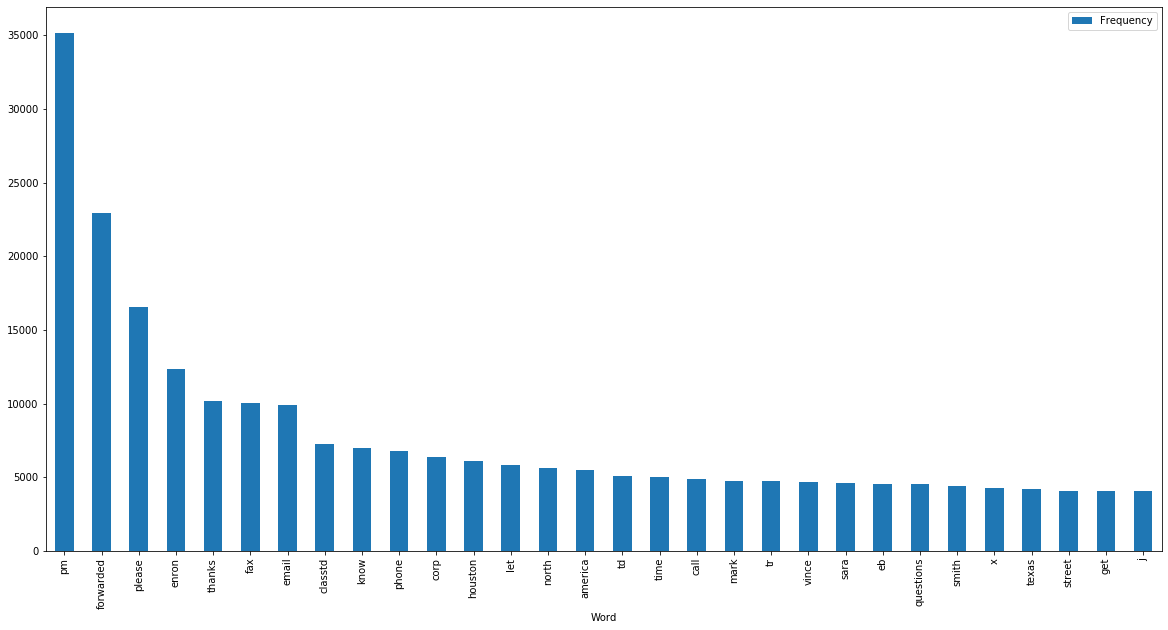

In [38]:
word_data = []
#Sort dictionary by highest word frequency. 
for key, value in sorted(freq_words.items(), key=lambda item: item[1], reverse=True):
    word_data.append([key, freq_words[key]])

#Prepare to plot bar graph of top words. 
#Create dataframe with Word and Frequency, then sort in Descending order. 
freq_words_df = pd.DataFrame.from_dict(freq_words, orient='index').reset_index()
freq_words_df = freq_words_df.rename(columns={"index": "Word", 0: "Frequency"})
freq_words_df = freq_words_df.sort_values(by=['Frequency'],ascending = False)
freq_words_df.reset_index(drop = True, inplace=True)
freq_words_df.head(30).plot(x='Word', kind='bar', figsize=(20,10))

### B. BC3 Corpus

In [39]:
bc3_df.head()

,body,date,email_num,from,listno,subject,to,annotator,summary,extractive_sentences,tokenized_body
0,"The IETF meetings tend to become too large, cr...",1998-12-08 15:30:52+00:00,1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator3-Part2,"Jacob suggested to hold two week meetings, the...","[The IETF meetings tend to become too large, c...",[ietf meetings tend become large creating logi...
1,"The IETF meetings tend to become too large, cr...",1998-12-08 15:30:52+00:00,1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator2-Part2,Jacob suggests that future IETF meetings be sp...,"[The IETF meetings tend to become too large, c...",[ietf meetings tend become large creating logi...
2,"The IETF meetings tend to become too large, cr...",1998-12-08 15:30:52+00:00,1,Jacob Palme <jpalme@dsv.su.se>,007-7484738,Extending IETF meetings to two weeks?,discuss@apps.ietf.org,Annotator1-Part1,The topic is the logistics of scheduling IETF ...,"[The IETF meetings tend to become too large, c...",[ietf meetings tend become large creating logi...
3,"> The IETF meetings tend to become too large, ...",1998-12-10 04:21:11+00:00,2,Terry Allen <tallen@sonic.net>,007-7484738,Re: Extending IETF meetings to two weeks?,"discuss@apps.ietf.org,jpalme@dsv.su.se",Annotator3-Part2,Terry supported Jacob's idea and suggested a f...,"[> The IETF meetings tend to become too large,...",[ietf meetings tend become large creating logi...
4,"> The IETF meetings tend to become too large, ...",1998-12-10 04:21:11+00:00,2,Terry Allen <tallen@sonic.net>,007-7484738,Re: Extending IETF meetings to two weeks?,"discuss@apps.ietf.org,jpalme@dsv.su.se",Annotator2-Part2,Some argue that it'd be more useful to prepare...,"[> The IETF meetings tend to become too large,...",[ietf meetings tend become large creating logi...


In [40]:
bc3_df['to'].value_counts().head()

w3c-wai-ig@w3.org                          65
WAI AU Guidelines <w3c-wai-au@w3.org>      35
w3c-wai-gl@w3.org                          27
Brian McBride <bwm@hplb.hpl.hp.com>        21
Charles McCathieNevile <charles@w3.org>    15
Name: to, dtype: int64